# YOLO-NAS training on custom dataset

Notebook made based on [YOLO-NAS Notebook](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolo-nas-on-custom-dataset.ipynb) by Roboflow.


## Before start

In [1]:
!nvidia-smi

Sun Jan 14 12:48:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Install YOLO-NAS


In [2]:
!pip install -q git+https://github.com/Deci-AI/super-gradients.git@stable
!pip install -q roboflow
!pip install -q supervision

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 6.9 MB/s eta 0:00:00
  Installing bui

### Restart the runtime

**After installation is complete, you'll need to restart the runtime after installation completes. Navigate to `Runtime` -> `Restart runtime` and confirm by clicking `Yes` when you see the popup.**

After that, carry on with the notebook starting from the cell below 👇

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install roboflow, download dataset

In [4]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

rf = Roboflow(api_key="API_KEY")
project = rf.workspace("roboflow-100").project("animals-ij5d2")
dataset = project.version(2).download("yolov5")

/content
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Football-Players-Detection-1 in yolov5pytorch:: 100%|██████████| 2258/2258 [00:00<00:00, 2817.53it/s]


In [5]:
LOCATION = dataset.location
print("location:", LOCATION)
CLASSES = sorted(project.classes.keys())
print("classes:", CLASSES)

location: /content/Football-Players-Detection-1
classes: ['ball', 'goalkeeper', 'player', 'referee']


## Fine-tune on custom dataset

`ckpt_root_dir` - this is the directory where results from all your experiments will be saved

`experiment_name` - all checkpoints, logs, and tensorboards will be saved in a directory with the name you specify here.

In [6]:
import torch

MODEL_ARCH = 'yolo_nas_s'
BATCH_SIZE = 8
MAX_EPOCHS = 1
CHECKPOINT_DIR = f'{HOME}/checkpoints'
EXPERIMENT_NAME = project.name.lower().replace(" ", "_")
DEVICE = 'cuda' if torch.cuda.is_available() else "cpu"

In [7]:
from super_gradients.training import Trainer

trainer = Trainer(experiment_name=EXPERIMENT_NAME, ckpt_root_dir=CHECKPOINT_DIR)

[2024-01-14 12:50:58] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-01-14 12:50:58] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-01-14 12:50:58] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-01-14 12:51:11] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-01-14 12:51:11] WARNING - export.py - Failed to import pytorch_quantization
[2024-01-14 12:51:11] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-01-14 12:51:11] INFO - env_sanity_check.py - Library check is not supported when super_gradients installed through "git+https://github.com/..." command


In [8]:
dataset_params = {
    'data_dir': LOCATION,
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': CLASSES
}

In [9]:
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val)

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': BATCH_SIZE,
        'num_workers': 2
    }
)

[2024-01-14 12:51:11] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1072/1072 [00:00<00:00, 4179.59it/s]
[2024-01-14 12:51:11] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 38/38 [00:00<00:00, 2433.26it/s]
[2024-01-14 12:51:12] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.


### Instantiate the model

In [10]:
from super_gradients.training import models

model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    pretrained_weights="coco"
)

Indexing dataset annotations: 100%|██████████| 13/13 [00:00<00:00, 2451.05it/s]
[2024-01-14 12:51:13] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:06<00:00, 44.1MB/s]
[2024-01-14 12:51:20] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


### Define metrics and training parameters

In [11]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "LinearEpochLRWarmup",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": MAX_EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

### Train the model

In [12]:
trainer.train(
    model=model,
    training_params=train_params,
    train_loader=train_data,
    valid_loader=val_data
)

[2024-01-14 12:51:20] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240114_125120_740836`
[2024-01-14 12:51:20] INFO - sg_trainer.py - Checkpoints directory: /content/checkpoints/football_players_detection/RUN_20240114_125120_740836
[2024-01-14 12:51:20] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to /content/checkpoints/football_players_detection/RUN_20240114_125120_740836/console_Jan14_12_51_20.txt


[2024-01-14 12:51:22] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            1072       (len(train_set))
    - Batch size per GPU:           8          (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             8          (num_gpus * batch_size)
    - Effective Batch size:         8          (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         134        (len(train_loader))
    - Gradient updates per epoch:   134        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_L  (66.91M parameters, 66.91M optimized)
    - Learning Rates and Weight Decays:
      - default: (66.91M parameters). LR: 0.0005 (66.91M parameters) WD: 0.0, (84.70K parameters), WD: 0.0001, (66.82M parameters)

[2024-01-14 12:51:22] INFO - sg_trainer.py - Started training for 1

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.2736
│   ├── Ppyoloeloss/loss_iou = 0.8694
│   ├── Ppyoloeloss/loss_dfl = 0.4479
│   └── Ppyoloeloss/loss = 3.591
└── Validation
    ├── Ppyoloeloss/loss_cls = 2.2344
    ├── Ppyoloeloss/loss_iou = 0.657
    ├── Ppyoloeloss/loss_dfl = 0.3317
    ├── Ppyoloeloss/loss = 3.2231
    ├── Precision@0.50 = 0.0
    ├── Recall@0.50 = 0.0
    ├── Map@0.50 = 0.0792
    └── F1@0.50 = 0.0



[2024-01-14 12:53:26] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 1:  80%|████████  | 4/5 [00:02<00:00,  1.96it/s]

## Zip and download fine-tuned model

In [13]:
# if you experience 'NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968' error, run code below 👇

import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [14]:
!zip -r yolo_nas.zip {CHECKPOINT_DIR}/{EXPERIMENT_NAME}

Validating epoch 1: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
[2024-01-14 12:53:30] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


  adding: content/checkpoints/football_players_detection/ (stored 0%)
  adding: content/checkpoints/football_players_detection/RUN_20240114_125120_740836/ (stored 0%)
  adding: content/checkpoints/football_players_detection/RUN_20240114_125120_740836/average_model.pth (deflated 8%)
  adding: content/checkpoints/football_players_detection/RUN_20240114_125120_740836/logs_Jan14_12_51_20.txt (deflated 71%)
  adding: content/checkpoints/football_players_detection/RUN_20240114_125120_740836/ckpt_latest.pth (deflated 8%)
  adding: content/checkpoints/football_players_detection/RUN_20240114_125120_740836/ckpt_best.pth

## Load trained model

You have to change the RUN folder in checkpoint_path

In [16]:
best_model = models.get(
    MODEL_ARCH,
    num_classes=len(dataset_params['classes']),
    checkpoint_path=f"{CHECKPOINT_DIR}/{EXPERIMENT_NAME}/RUN_20240114_125120_740836/average_model.pth",
).to(DEVICE)

### Analize trained model using supervision

In [17]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml",
    force_masks=False
)

print('dataset classes:', ds.classes)

Create callback function

In [19]:
import numpy as np

def callback(image: np.ndarray) -> sv.Detections:
    result = list(best_model.predict(image, fuse_model = False))[0]
    return sv.Detections.from_yolo_nas(result)



Calculate mAP per class

write to file because sometimes cell doesn't print the results

In [20]:
mean_average_precision = sv.MeanAveragePrecision.benchmark(
     dataset = ds,
     callback = callback
)
file_path = f"{HOME}/map_per_class.txt"
with open(file_path, "w") as file:
    file.write(f"mAP: {mean_average_precision.map50_95}\n")
    print('mAP:', mean_average_precision.map50_95)
    per_class_map = mean_average_precision.per_class_ap50_95.mean(axis=1)
    for class_name, value in zip(ds.classes, per_class_map):
        print(f"{class_name}: {value:.2f}")
        file.write(f"{class_name}: {value:.2f}\n")



Calculate confusion matrix

<class 'matplotlib.figure.Figure'>


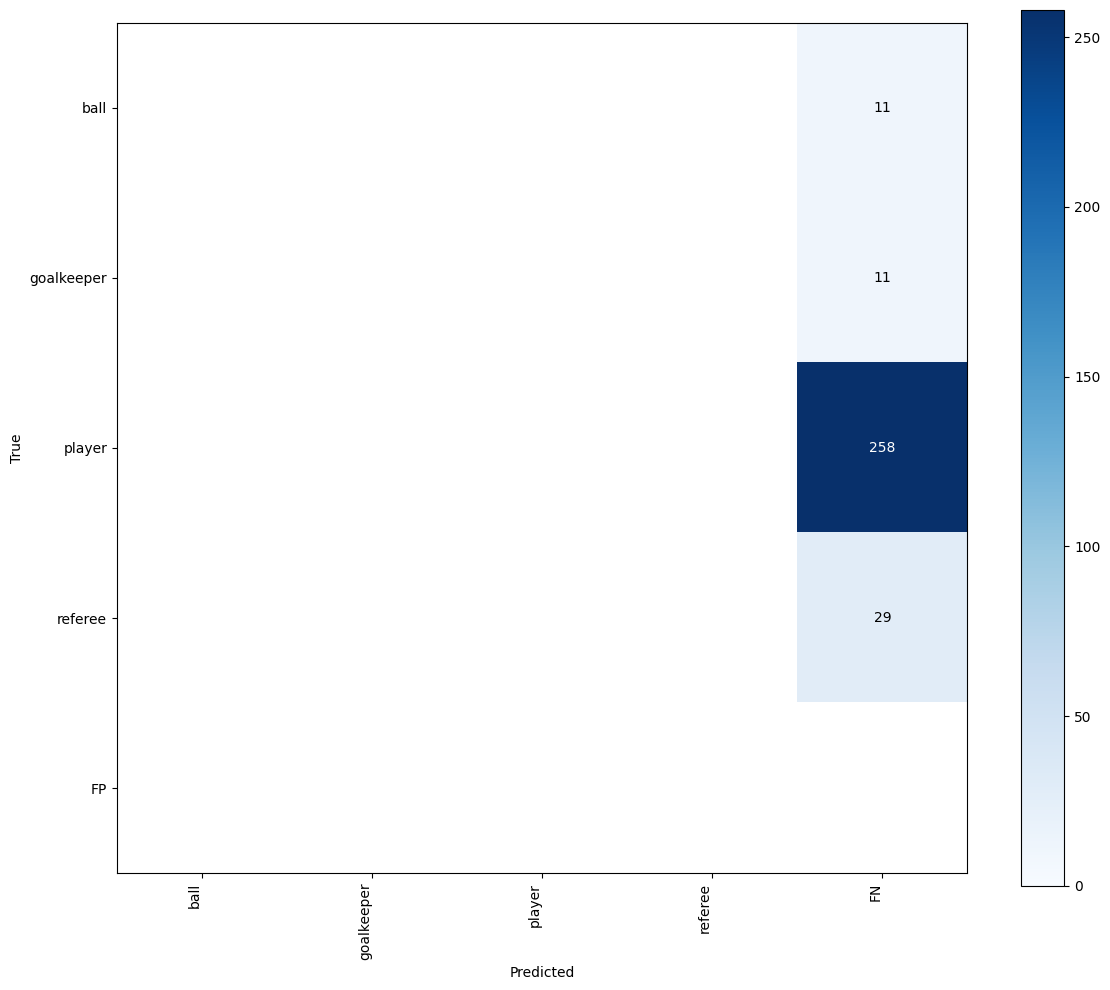

In [24]:
confusion_matrix = sv.ConfusionMatrix.benchmark(
     dataset = ds,
     callback = callback
)
confusion_matrix_plot = confusion_matrix.plot()
confusion_matrix_plot.savefig(f"{HOME}/confusion_matrix.png")